In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
def split_data(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

class biRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(biRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.biRNN = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.biRNN(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out
    
    
def train_mse(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = biRNN(input_dim, hidden_dim,  n_layers,output_dim)
    
    # Defining loss function and optimizer
    criterion1 = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    mseloss_train = []
    mseloss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        #h,c = model.init_hidden(batch_size)
        avg_loss1 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            #h = h.data
            #c = c.data
            model.zero_grad()
            
            out = model.forward(x.float())
            loss1 = criterion1(out, label.float())
            loss1.backward()
           
            optimizer.step()
            avg_loss1 += loss1.item()
        
        avg_loss1 /= length
        mseloss_train.append(avg_loss1)
        print("Epoch {}/{} Done, Total Training MSELoss: {}".format(epoch, EPOCHS, avg_loss1))
        
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        
        loss1 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss1 = 0.
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            testloss = criterion1(out, label.float()).item()
            avg_loss1 += testloss
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        mseloss_test.append(avg_loss1)    
        print("Total Testing MSELoss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, mseloss_train, mseloss_test, predictions, values

def train_l1(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = biRNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion2 = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    l1loss_train = []
    l1loss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        #h = model.init_hidden(batch_size)
        avg_loss2 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            #h = h.data
            model.zero_grad()

            out = model.forward(x.float())
            
            loss2 = criterion2(out, label.float())
            loss2.backward()
            optimizer.step()
            avg_loss2 += loss2.item()
        
        avg_loss2 /= length
        l1loss_train.append(avg_loss2)
        print("Epoch {}/{} Done, Total Training L1Loss: {}".format(epoch, EPOCHS, avg_loss2))
        
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion2 = nn.L1Loss()
        
        loss2 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            testloss = criterion2(out, label.float()).item()
            avg_loss2 += testloss
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
        
        l1loss_test.append(avg_loss2)
        print("Total Testing L1Loss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, l1loss_train, l1loss_test, predictions, values

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        criterion2 = nn.L1Loss()
        
        loss1 = 0
        loss2 = 0
        for x, label in test_loader:
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            loss1 = criterion1(out, label.float()).item()
            loss2 = criterion2(out, label.float()).item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        print("Total MSELoss: {}".format(loss1))
        print("Total L1Loss: {}".format(loss2))
        
            
    return predictions, values, loss1,loss2

In [46]:
def plot(predictions, values, dataset_name):
    plt.figure(figsize=(14,10))
    plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
    plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
    plt.title('Predicted and actual values on {}'.format(dataset_name))
    plt.ylabel(dataset_name)
    plt.xlabel('Time Points')
    plt.legend()

def plot_loss(loss_train, loss_test, dataset_name, isL1):
    loss_name = "L1" if isL1 else "MSE"
    plt.figure(figsize=(6, 4))
    plt.plot(loss_train, color="g", label="Training")
    plt.plot(loss_test, color="b", label="Testing")
    plt.title('Plot of train and test {} loss vs iterations for {}'.format(loss_name, dataset_name))
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss' if isL1 else 'MSE Loss')
    plt.legend()

def run(dataset_df, column_i, dataset_name, date_column):
    dataset_df[date_column] = pd.to_datetime(dataset_df[date_column])
    dataset_df.set_index(date_column,inplace=True)
    dataset_df = pd.DataFrame(dataset_df[dataset_df.columns[column_i-1]])
    dataset_df.dropna(inplace=True)

    # Scaling the input data
    sc = MinMaxScaler()
    #label_sc = MinMaxScaler()
    scaled_data = sc.fit_transform(dataset_df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    #label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))
    lookback = 5
    train_x,train_y,test_x,test_y = split_data(scaled_data, lookback)

    # Print data shape
    print('X_train.shape: ', train_x.shape)
    print('y_train.shape: ', train_y.shape)
    print('X_test.shape: ', test_x.shape) 
    print('y_test.shape: ', test_y.shape)

    batch_size = 32
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
    test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

    lr = 0.001
    gru_model5, mseloss_train, mseloss_test, predictions, values = train_mse(train_loader, test_loader,lr,EPOCHS=50, model_type="Bidirectional RNN")
    gru_model5, l1loss_train, l1loss_test, predictions, values = train_l1(train_loader, test_loader,lr,EPOCHS=50, model_type="Bidirectional RNN")

    plot(predictions, values, dataset_name)
    plot_loss(mseloss_train, mseloss_test, dataset_name, False)
    plot_loss(l1loss_train, l1loss_test, dataset_name, True)

In [47]:
dataset_folder = "../../dataset/"
artificial_data1 = pd.read_csv(dataset_folder + "Artificial_trend.csv")
artificial_data2 = pd.read_csv(dataset_folder + "Artificial_trend1.csv")
msft_data = pd.read_csv(dataset_folder + "microsoft.csv")
oil_data = pd.read_csv(dataset_folder + "oil.csv")
sp500_data = pd.read_csv(dataset_folder + "sp500.csv")
bitcoin_data = pd.read_csv(dataset_folder + "coin.csv")

## Artificial Data 1

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.025057707531192176
Total Testing MSELoss: 0.002583813853561878
Total Time Elapsed: 1.260323499999913 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.003405369049157873
Total Testing MSELoss: 7.508214912377298e-05
Total Time Elapsed: 1.1726955000000316 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.0004889518239216848
Total Testing MSELoss: 6.211087747942656e-05
Total Time Elapsed: 1.1922814000000699 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0006980951538835242
Total Testing MSELoss: 0.0006947430083528161
Total Time Elapsed: 1.2127806999999393 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0009223656186525029
Total Testing MSELoss: 0.0006690392619930208
Total Time Elapsed: 1.1739891999999372 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0007312311106863569
Total Testing MSELoss

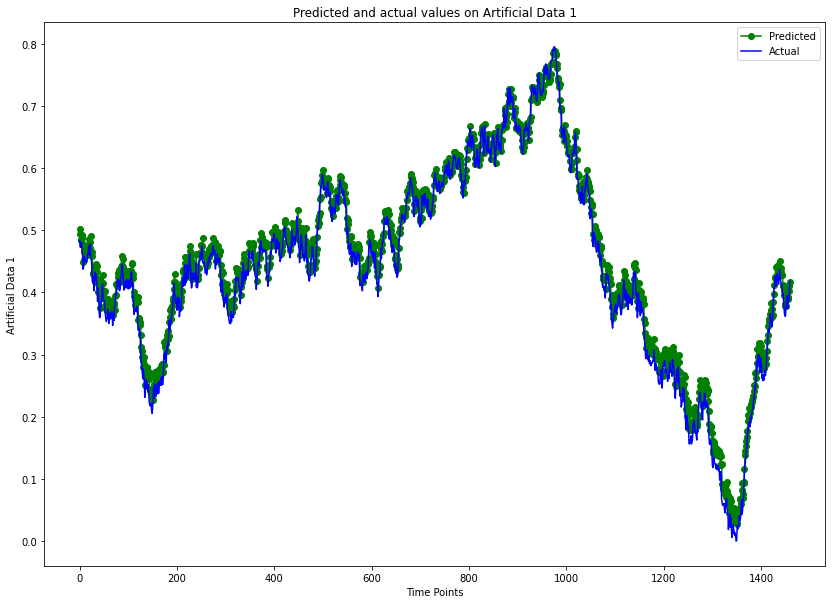

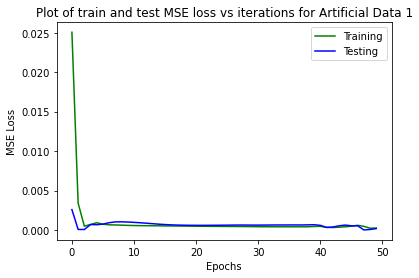

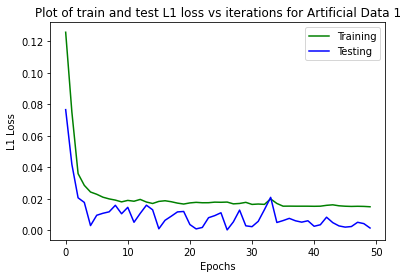

In [48]:
run(artificial_data1, 1, "Artificial Data 1", "date")

## Artificial Data 2

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.03314441102002792
Total Testing MSELoss: 0.09195254743099213
Total Time Elapsed: 1.1453945999999178 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.00974412799309453
Total Testing MSELoss: 0.002187386155128479
Total Time Elapsed: 1.1595024000000649 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.0013544525966978284
Total Testing MSELoss: 0.0017620074795559049
Total Time Elapsed: 1.1687796999999591 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0013305314182166961
Total Testing MSELoss: 0.0018809938337653875
Total Time Elapsed: 1.221089199999824 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0014461075734688675
Total Testing MSELoss: 0.00169613235630095
Total Time Elapsed: 1.127102700000023 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0011947484791552606
Total Testing MSELoss: 0.001

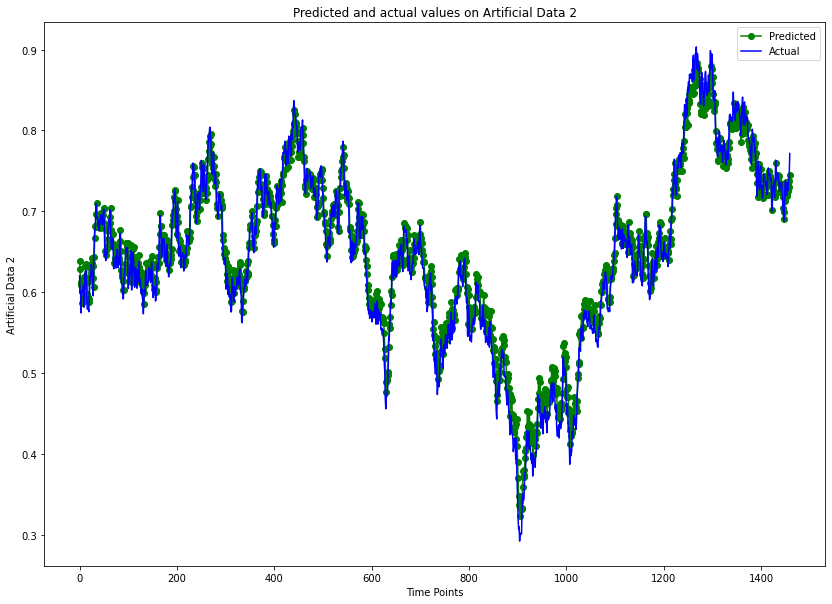

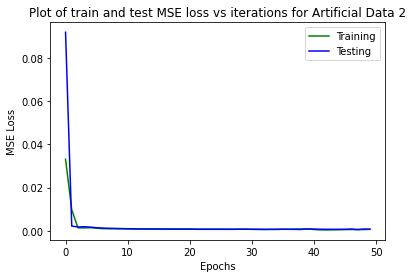

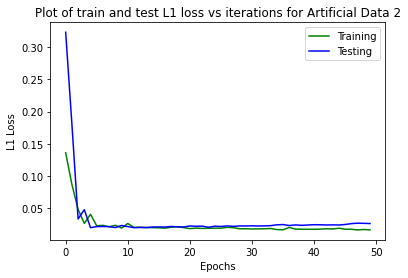

In [49]:
run(artificial_data2, 1, "Artificial Data 2", "date")

## Microsoft

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.0031591587235075044
Total Testing MSELoss: 0.14580878615379333
Total Time Elapsed: 0.2690597999999227 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.024591049935544427
Total Testing MSELoss: 0.04824959114193916
Total Time Elapsed: 0.2503931000001103 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.027941817392176646
Total Testing MSELoss: 0.10497380048036575
Total Time Elapsed: 0.24952589999998054 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.014993596414078146
Total Testing MSELoss: 0.047845590859651566
Total Time Elapsed: 0.25227879999988545 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0056995043161952854
Total Testing MSELoss: 0.005502903368324041
Total Time Elapsed: 0.2546624999999949 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0009774195763433504
Total Testing MSELoss: 7.001

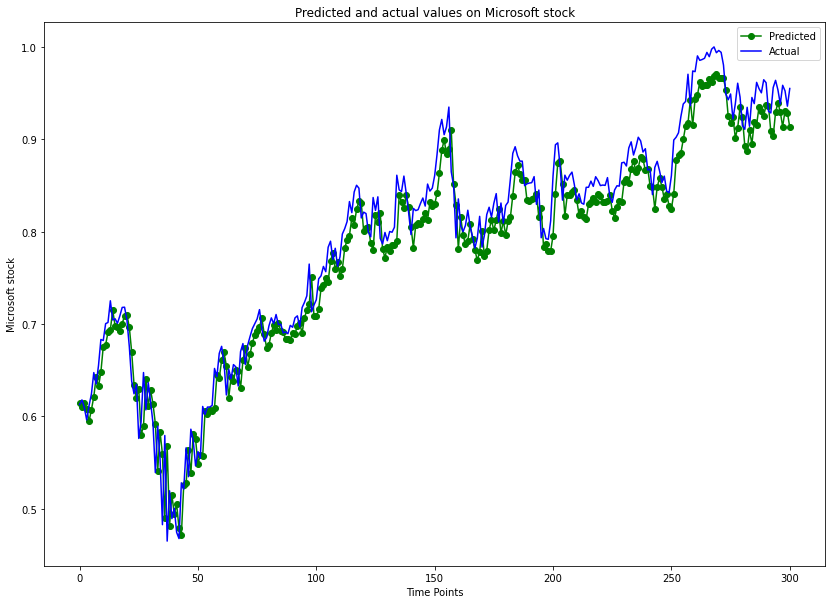

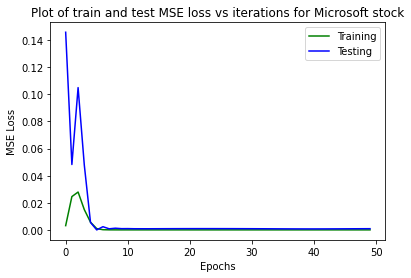

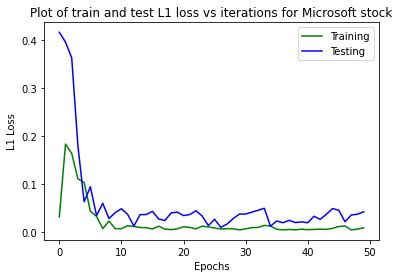

In [50]:
run(msft_data, 4, "Microsoft stock", "Date")

## Crude oil prices

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.030885420743097233
Total Testing MSELoss: 0.1916617900133133
Total Time Elapsed: 0.25601080000001275 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.03996600319729432
Total Testing MSELoss: 0.07166559994220734
Total Time Elapsed: 0.2429735000000619 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.04232218366048887
Total Testing MSELoss: 0.02567160315811634
Total Time Elapsed: 0.24831859999994776 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.03210921109329272
Total Testing MSELoss: 0.02053157426416874
Total Time Elapsed: 0.27480629999990924 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.026043436160666476
Total Testing MSELoss: 0.01129894144833088
Total Time Elapsed: 0.27251810000007026 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.019399332351320863
Total Testing MSELoss: 0.0074703842

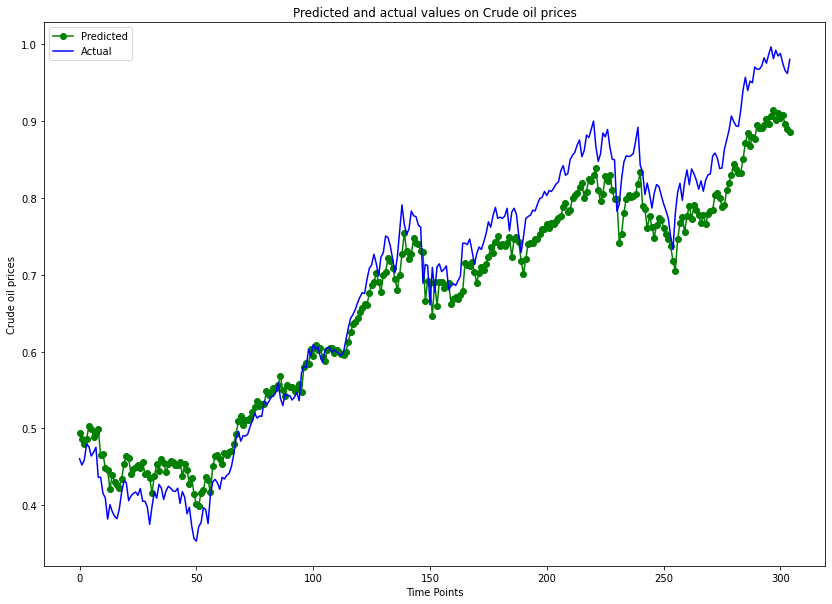

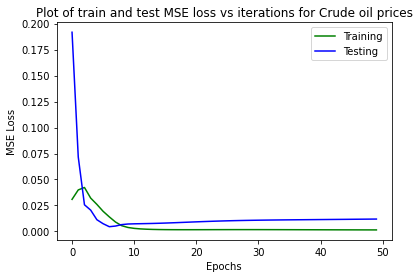

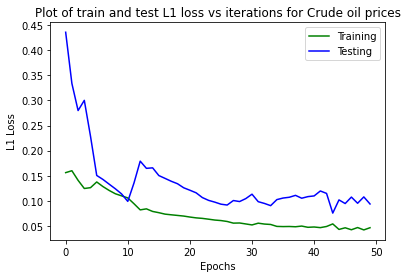

In [51]:
oil_data = oil_data[oil_data.DCOILBRENTEU != "."]
run(oil_data, 1, "Crude oil prices", "DATE")

## S&P 500

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.0001818003438994641
Total Testing MSELoss: 0.8301436901092529
Total Time Elapsed: 0.3075547999999344 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.0006222544357993601
Total Testing MSELoss: 0.7506467700004578
Total Time Elapsed: 0.3052000999998654 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.0005082180179995662
Total Testing MSELoss: 0.6796807050704956
Total Time Elapsed: 0.2741996999998264 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0004953453640026014
Total Testing MSELoss: 0.6368600726127625
Total Time Elapsed: 0.29088819999992666 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0005521162054794682
Total Testing MSELoss: 0.5958293080329895
Total Time Elapsed: 0.28246150000018133 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0005303762898808305
Total Testing MSELoss: 0.5646217

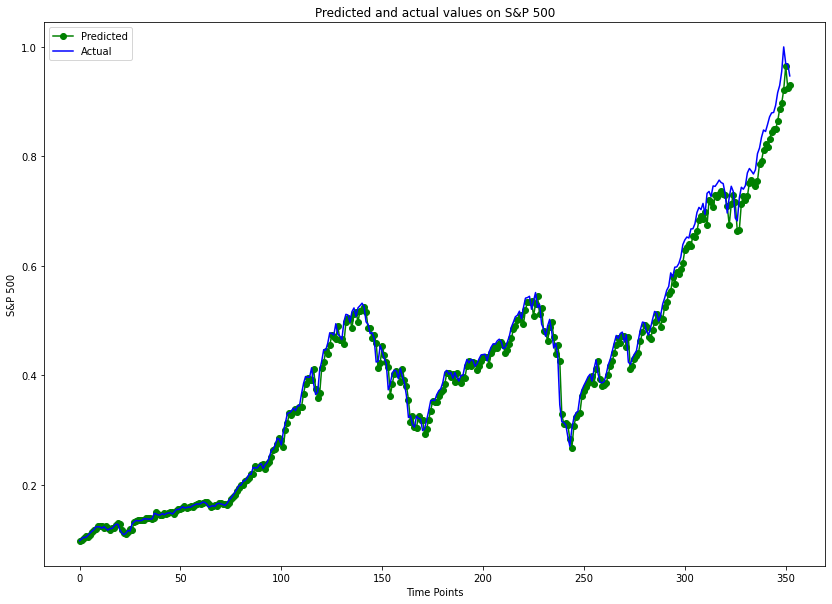

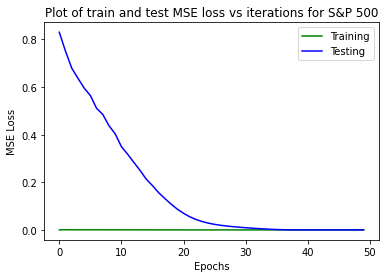

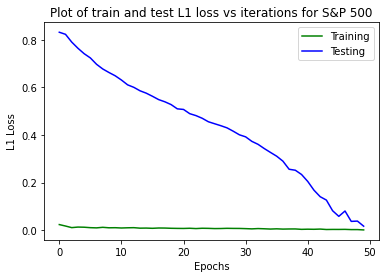

In [ ]:
run(sp500_data, 1, "S&P 500", "Date")

## S&P 500

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.0001818003438994641
Total Testing MSELoss: 0.8301436901092529
Total Time Elapsed: 0.3075547999999344 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.0006222544357993601
Total Testing MSELoss: 0.7506467700004578
Total Time Elapsed: 0.3052000999998654 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.0005082180179995662
Total Testing MSELoss: 0.6796807050704956
Total Time Elapsed: 0.2741996999998264 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0004953453640026014
Total Testing MSELoss: 0.6368600726127625
Total Time Elapsed: 0.29088819999992666 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0005521162054794682
Total Testing MSELoss: 0.5958293080329895
Total Time Elapsed: 0.28246150000018133 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0005303762898808305
Total Testing MSELoss: 0.5646217

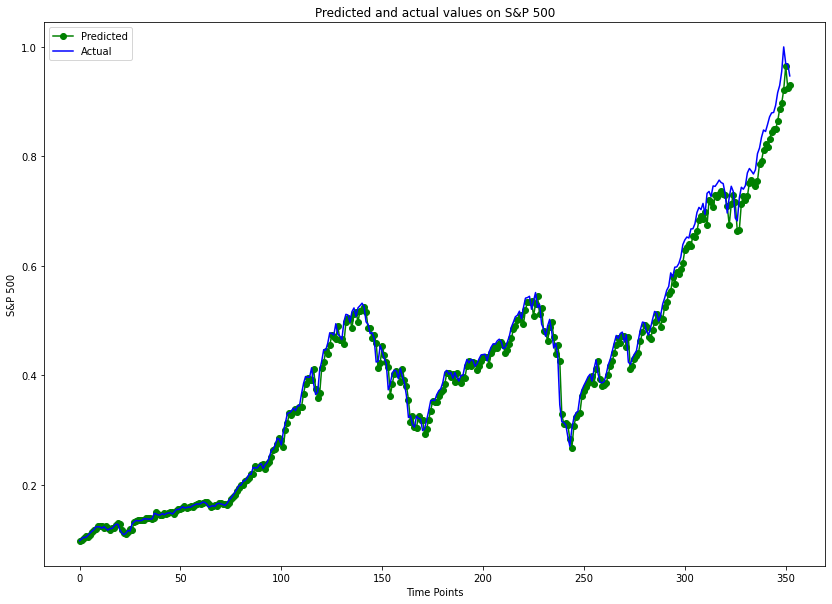

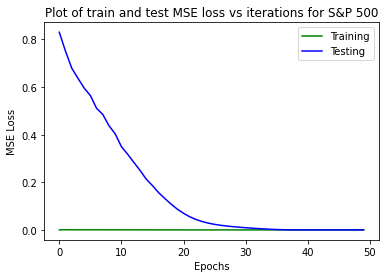

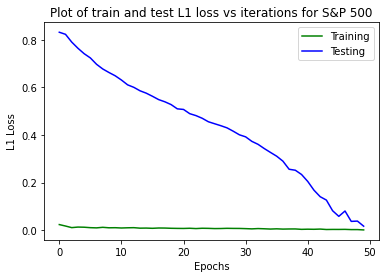

In [52]:
run(sp500_data, 1, "S&P 500", "Date")

## Bitcoin

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.0028075104918205375
Total Testing MSELoss: 0.17369632422924042
Total Time Elapsed: 0.5132178999999724 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.002455863695880803
Total Testing MSELoss: 0.13843286037445068
Total Time Elapsed: 0.5058223999999427 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.001919000772674637
Total Testing MSELoss: 0.13081732392311096
Total Time Elapsed: 0.5035227000000759 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0015830570858261003
Total Testing MSELoss: 0.10578258335590363
Total Time Elapsed: 0.48568569999997635 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0013900135420917927
Total Testing MSELoss: 0.09252186119556427
Total Time Elapsed: 0.5036700999999084 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0012333323617573987
Total Testing MSELoss: 0.08111

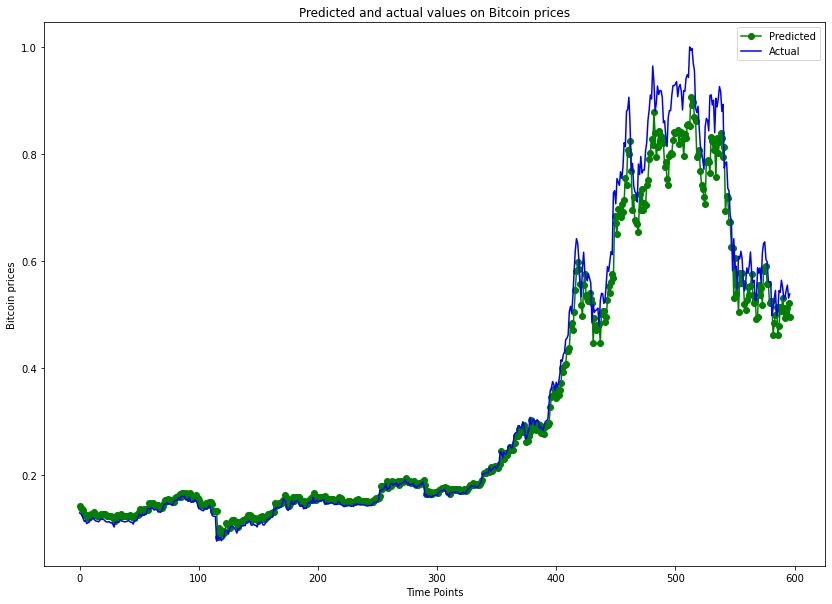

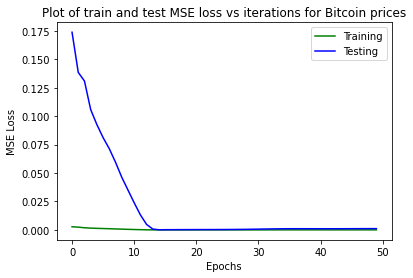

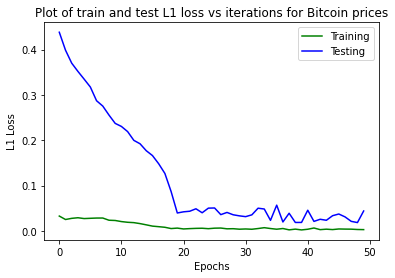

In [53]:
run(bitcoin_data, 7, "Bitcoin prices", "Date")